In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
##import data
beta_marginal = pd.read_csv('data/beta_marginal.csv.gz')
LD = pd.read_csv('data/LD.csv.gz')
X_test = pd.read_csv('data/X_test.csv.gz')
X_train = pd.read_csv('data/X_train.csv.gz')
y_test = pd.read_csv('data/y_test.csv.gz')
y_train = pd.read_csv('data/y_train.csv.gz')

R = LD.set_index('Unnamed: 0').values
beta = beta_marginal.set_index('Unnamed: 0').values
X_train = X_train.set_index('Unnamed: 0').values
y_train = y_train.set_index('Unnamed: 0').values
X_test = X_test.set_index('Unnamed: 0').values
y_test = y_test.set_index('Unnamed: 0').values

In [3]:
##fixed constant
M = 100 
N_train = 439 
N_test = 50

## Part 1-3

In [4]:
def ELBO(iteration = 10):
    '''
    initialize posterior
    '''
    miu_post = np.zeros(M)
    tao_beta_post = np.empty(M)
    tao_beta_post.fill(1)
    gamma_post = np.empty(M)
    gamma_post.fill(0.01)
    tao_epsilon = 1 
    tao_beta = 200 
    pi = 0.01
    ELBO_list = []
    for ite in range(iteration+1):
        '''
        E step
        '''
        for j in range(M):
            tao_beta_post[j] = np.diag(R * N_train)[j] * tao_epsilon + tao_beta
            sum_tmp = 0
            for i in range(M):
                if i != j :
                    sum_tmp += gamma_post[i] * miu_post[i] * R[i][j]
            miu_post[j] = N_train*(tao_epsilon / tao_beta_post[j])*(beta[j] - sum_tmp)
            u_j = np.log(pi/(1-pi)) + (1/2)*np.log(tao_beta/tao_beta_post[j]) + (tao_beta_post[j]/2) * np.square(miu_post[j])
            gamma_post[j] = 1/(1+np.exp(-u_j))

        for idx, gamma in enumerate(gamma_post):
            if gamma < 0.01:
                gamma_post[idx] = 0.01
            elif gamma > 0.99 :
                gamma_post[idx] = 0.99

        '''
        M step
        '''
        tao_beta_inv = sum(gamma_post * np.add(np.square(miu_post), 1/tao_beta_post)) / sum(gamma_post)
        tao_beta = 1/tao_beta_inv
        pi = sum(gamma_post/M)
    
        '''
        ELBO
        '''
        term_sum = 0
        for j in range(M):
            for k in range(j+1, M):
                term_sum += gamma_post[j]*miu_post[j]*gamma_post[k]*miu_post[k]*R[k][j]*N_train
        term_1 = (N_train/2)*np.log(tao_epsilon) \
        - (tao_epsilon/2)*N_train \
        + tao_epsilon*((gamma_post*miu_post).T) @ (beta * N_train) \
        - np.sum(tao_epsilon/2*(gamma_post*(np.square(miu_post) + (1/tao_beta_post))*np.diag(R*N_train))) \
        - tao_epsilon*(term_sum)

        term_2 = M * ((-1/2) * np.log(2*pi*tao_beta_inv)) - sum((tao_beta/2) * gamma_post * (np.square(miu_post)+(1/tao_beta_post)))
        term_3 = M * ((-1/2) * np.log(2*pi*tao_beta_inv))- 1/2*sum(gamma_post*np.log(tao_beta))

        term_4 = sum(gamma_post * np.log(pi) + (1-gamma_post)*np.log(1-pi))
        term_5 = sum(gamma_post * np.log(gamma_post) + (1-gamma_post)*np.log(1-gamma_post))
        ELBO = term_1 + term_2 + term_4 - term_3 - term_5
        ELBO_list.append(ELBO[0])
    return ELBO_list, gamma_post, miu_post

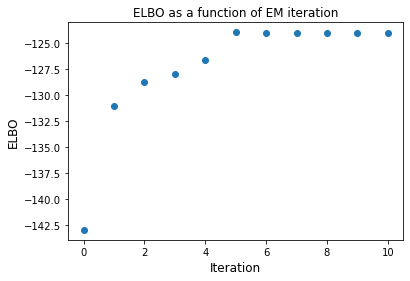

In [5]:
ELBO_list, gamma_post, miu_post = ELBO()
##Part 3 Plot
plt.scatter(range(len(ELBO_list)), ELBO_list)
plt.xlabel('Iteration', fontdict  = {'size': 12})
plt.ylabel('ELBO', fontdict  = {'size': 12})
plt.title("ELBO as a function of EM iteration")
plt.show()

## Part 4

In [6]:
y_train_predict = X_train @ (gamma_post*miu_post)
y_train = y_train.reshape(N_train)
y_test_predict = X_test @ (gamma_post*miu_post)
y_test = y_test.reshape(N_test)
print('Pearson correlation for train data:',stats.pearsonr(y_train, y_train_predict)[0])
print('Pearson correlation for test data:',stats.pearsonr(y_test, y_test_predict)[0])

Pearson correlation for train data: 0.6935590008481706
Pearson correlation for test data: 0.5029934806056697


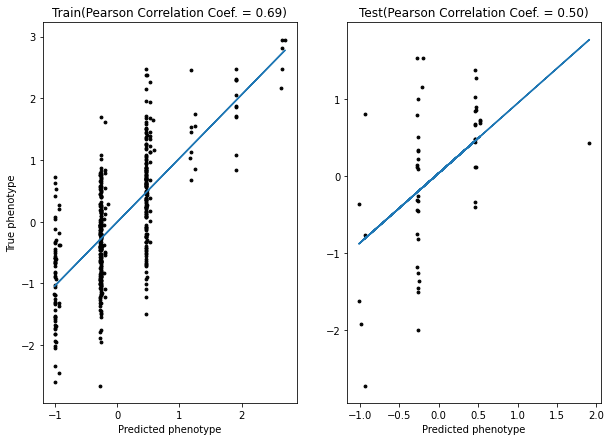

In [7]:
##Part 4 Plot
figure, axis = plt.subplots(1,2, figsize=(10, 7))

a, b = np.polyfit(y_train_predict, y_train, 1)
axis[0].scatter(y_train_predict, y_train,color = 'black', s = 8)
axis[0].plot(y_train_predict, a*y_train_predict+b)
axis[0].set_xlabel('Predicted phenotype')
axis[0].set_ylabel('True phenotype')
axis[0].set_title("Train(Pearson Correlation Coef. = 0.69)")

c, d = np.polyfit(y_test_predict, y_test, 1)
axis[1].scatter(y_test_predict, y_test,color = 'black', s = 8)
axis[1].plot(y_test_predict, c*y_test_predict+d)
axis[1].set_xlabel('Predicted phenotype')
axis[1].set_title("Test(Pearson Correlation Coef. = 0.50)")
plt.show()

## Part 5

In [8]:
snp = LD['Unnamed: 0'].tolist()
fine_map = pd.DataFrame({'SNP': snp,'PIP': gamma_post,})
causal_onehot = np.zeros(len(gamma_post))
for s in ['rs9482449', 'rs7771989', 'rs2169092']:
    causal_onehot[snp.index(s)] = 1
fine_map['causal'] = causal_onehot

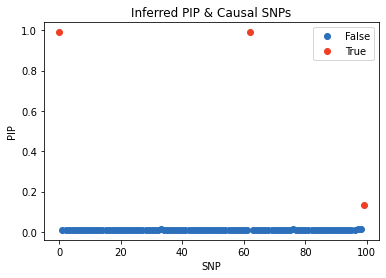

In [9]:
groups = fine_map.groupby('causal')
colors = ['#2c6fbb', '#ef4026']
for oh, group in groups:
    plt.plot(group.index, group['PIP'], marker='o', linestyle='', label=bool(oh), color = colors[int(oh)])
plt.legend()
plt.xlabel('SNP')
plt.ylabel('PIP')
plt.title("Inferred PIP & Causal SNPs")
plt.show()